In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

import optuna

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss

from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -P /tmp
plt.style.use("/tmp/rose-pine-dawn.mplstyle")

--2024-01-01 10:30:45--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/plain]
Saving to: '/tmp/rose-pine-dawn.mplstyle'

rose-pine-dawn.mpls 100%[===================>]  39.95K  --.-KB/s    in 0.01s   

2024-01-01 10:30:45 (3.66 MB/s) - '/tmp/rose-pine-dawn.mplstyle' saved [40905/40905]



In [2]:
# Load thg Data
train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv').drop(columns=['id'],axis=1)
test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv').drop("id",axis=1)
sample_submisiion = pd.read_csv('/kaggle/input/playground-series-s3e26/sample_submission.csv')

In [3]:
def analyze_dataframe(df):
    """
    Analyze a pandas DataFrame and provide a summary of its characteristics.

    Parameters:
    df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
    None
    """
    print("DataFrame Information:")
    print("----------------------")
    display(df.info(verbose=True, show_counts=True))
    print("\n")

    print("DataFrame Values:")
    print("----------------------")
    display(df.head(5).T)
    print("\n")

    print("DataFrame Description:")
    print("----------------------")
    display(df.describe().T)
    print("\n")

    print("Number of Null Values:")
    print("----------------------")
    display(df.isnull().sum())
    print("\n")

    print("Number of Duplicated Rows:")
    print("--------------------------")
    display(df.duplicated().sum())
    print("\n")

    print("Number of Unique Values:")
    print("------------------------")
    display(df.nunique())
    print("\n")

    print("DataFrame Shape:")
    print("----------------")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Usage
analyze_dataframe(train)

DataFrame Information:
----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage 

None



DataFrame Values:
----------------------


0        1        2        3        4
N_Days                     999     2574     3428     2576      788
Drug           D-penicillamine  Placebo  Placebo  Placebo  Placebo
Age                      21532    19237    13727    18460    16658
Sex                          M        F        F        F        F
Ascites                      N        N        N        N        N
Hepatomegaly                 N        N        Y        N        Y
Spiders                      N        N        Y        N        N
Edema                        N        N        Y        N        N
Bilirubin                  2.3      0.9      3.3      0.6      1.1
Cholesterol              316.0    364.0    299.0    256.0    346.0
Albumin                   3.35     3.54     3.55      3.5     3.65
Copper                   172.0     63.0    131.0     58.0     63.0
Alk_Phos                1601.0   1440.0   1029.0   1653.0   1181.0
SGOT                     179.8   134.85   119.35     71.3   125.55
Tryglicerides             63.0     88.0     50.0     96.0     96.0
Platelets                394.0    361.0    199.0    269.0    298.0
Prothrombin                9.7     11.0     11.7     10.7     10.6
Stage                      3.0      3.0      4.0      3.0      4.0
Status                       D        C        D        C        C



DataFrame Description:
----------------------


count          mean          std      min       25%       50%  \
N_Days         7905.0   2030.173308  1094.233744    41.00   1230.00   1831.00   
Age            7905.0  18373.146490  3679.958739  9598.00  15574.00  18713.00   
Bilirubin      7905.0      2.594485     3.812960     0.30      0.70      1.10   
Cholesterol    7905.0    350.561923   195.379344   120.00    248.00    298.00   
Albumin        7905.0      3.548323     0.346171     1.96      3.35      3.58   
Copper         7905.0     83.902846    75.899266     4.00     39.00     63.00   
Alk_Phos       7905.0   1816.745250  1903.750657   289.00    834.00   1181.00   
SGOT           7905.0    114.604602    48.790945    26.35     75.95    108.50   
Tryglicerides  7905.0    115.340164    52.530402    33.00     84.00    104.00   
Platelets      7905.0    265.228969    87.465579    62.00    211.00    265.00   
Prothrombin    7905.0     10.629462     0.781735     9.00     10.00     10.60   
Stage          7905.0      3.032511     0.866511     1.00      2.00      3.00   

                    75%       max  
N_Days          2689.00   4795.00  
Age            20684.00  28650.00  
Bilirubin          3.00     28.00  
Cholesterol      390.00   1775.00  
Albumin            3.77      4.64  
Copper           102.00    588.00  
Alk_Phos        1857.00  13862.40  
SGOT             137.95    457.25  
Tryglicerides    139.00    598.00  
Platelets        316.00    563.00  
Prothrombin       11.00     18.00  
Stage              4.00      4.00



Number of Null Values:
----------------------


N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64



Number of Duplicated Rows:
--------------------------


0



Number of Unique Values:
------------------------


N_Days           461
Drug               2
Age              391
Sex                2
Ascites            2
Hepatomegaly       2
Spiders            2
Edema              3
Bilirubin        111
Cholesterol      226
Albumin          160
Copper           171
Alk_Phos         364
SGOT             206
Tryglicerides    154
Platelets        227
Prothrombin       49
Stage              4
Status             3
dtype: int64



DataFrame Shape:
----------------
Rows: 7905, Columns: 19


In [4]:
def cat_and_num(df):
    """
    Separates columns of a DataFrame into categorical and numerical lists.

    Parameters:
    - df (DataFrame): The DataFrame to process.

    Returns:
    - Tuple: (categorical_columns, numerical_columns)
    """    
    categorical_columns = [col for col in df.columns if df[col].dtype == "object" if col != 'Status' ]
    
    numerical_columns = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
    
    return categorical_columns, numerical_columns

In [5]:
categorical_columns_train , numerical_columns_train = cat_and_num(train)

In [6]:
numerical_columns_train

['N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage']

In [7]:
categorical_columns_train

['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

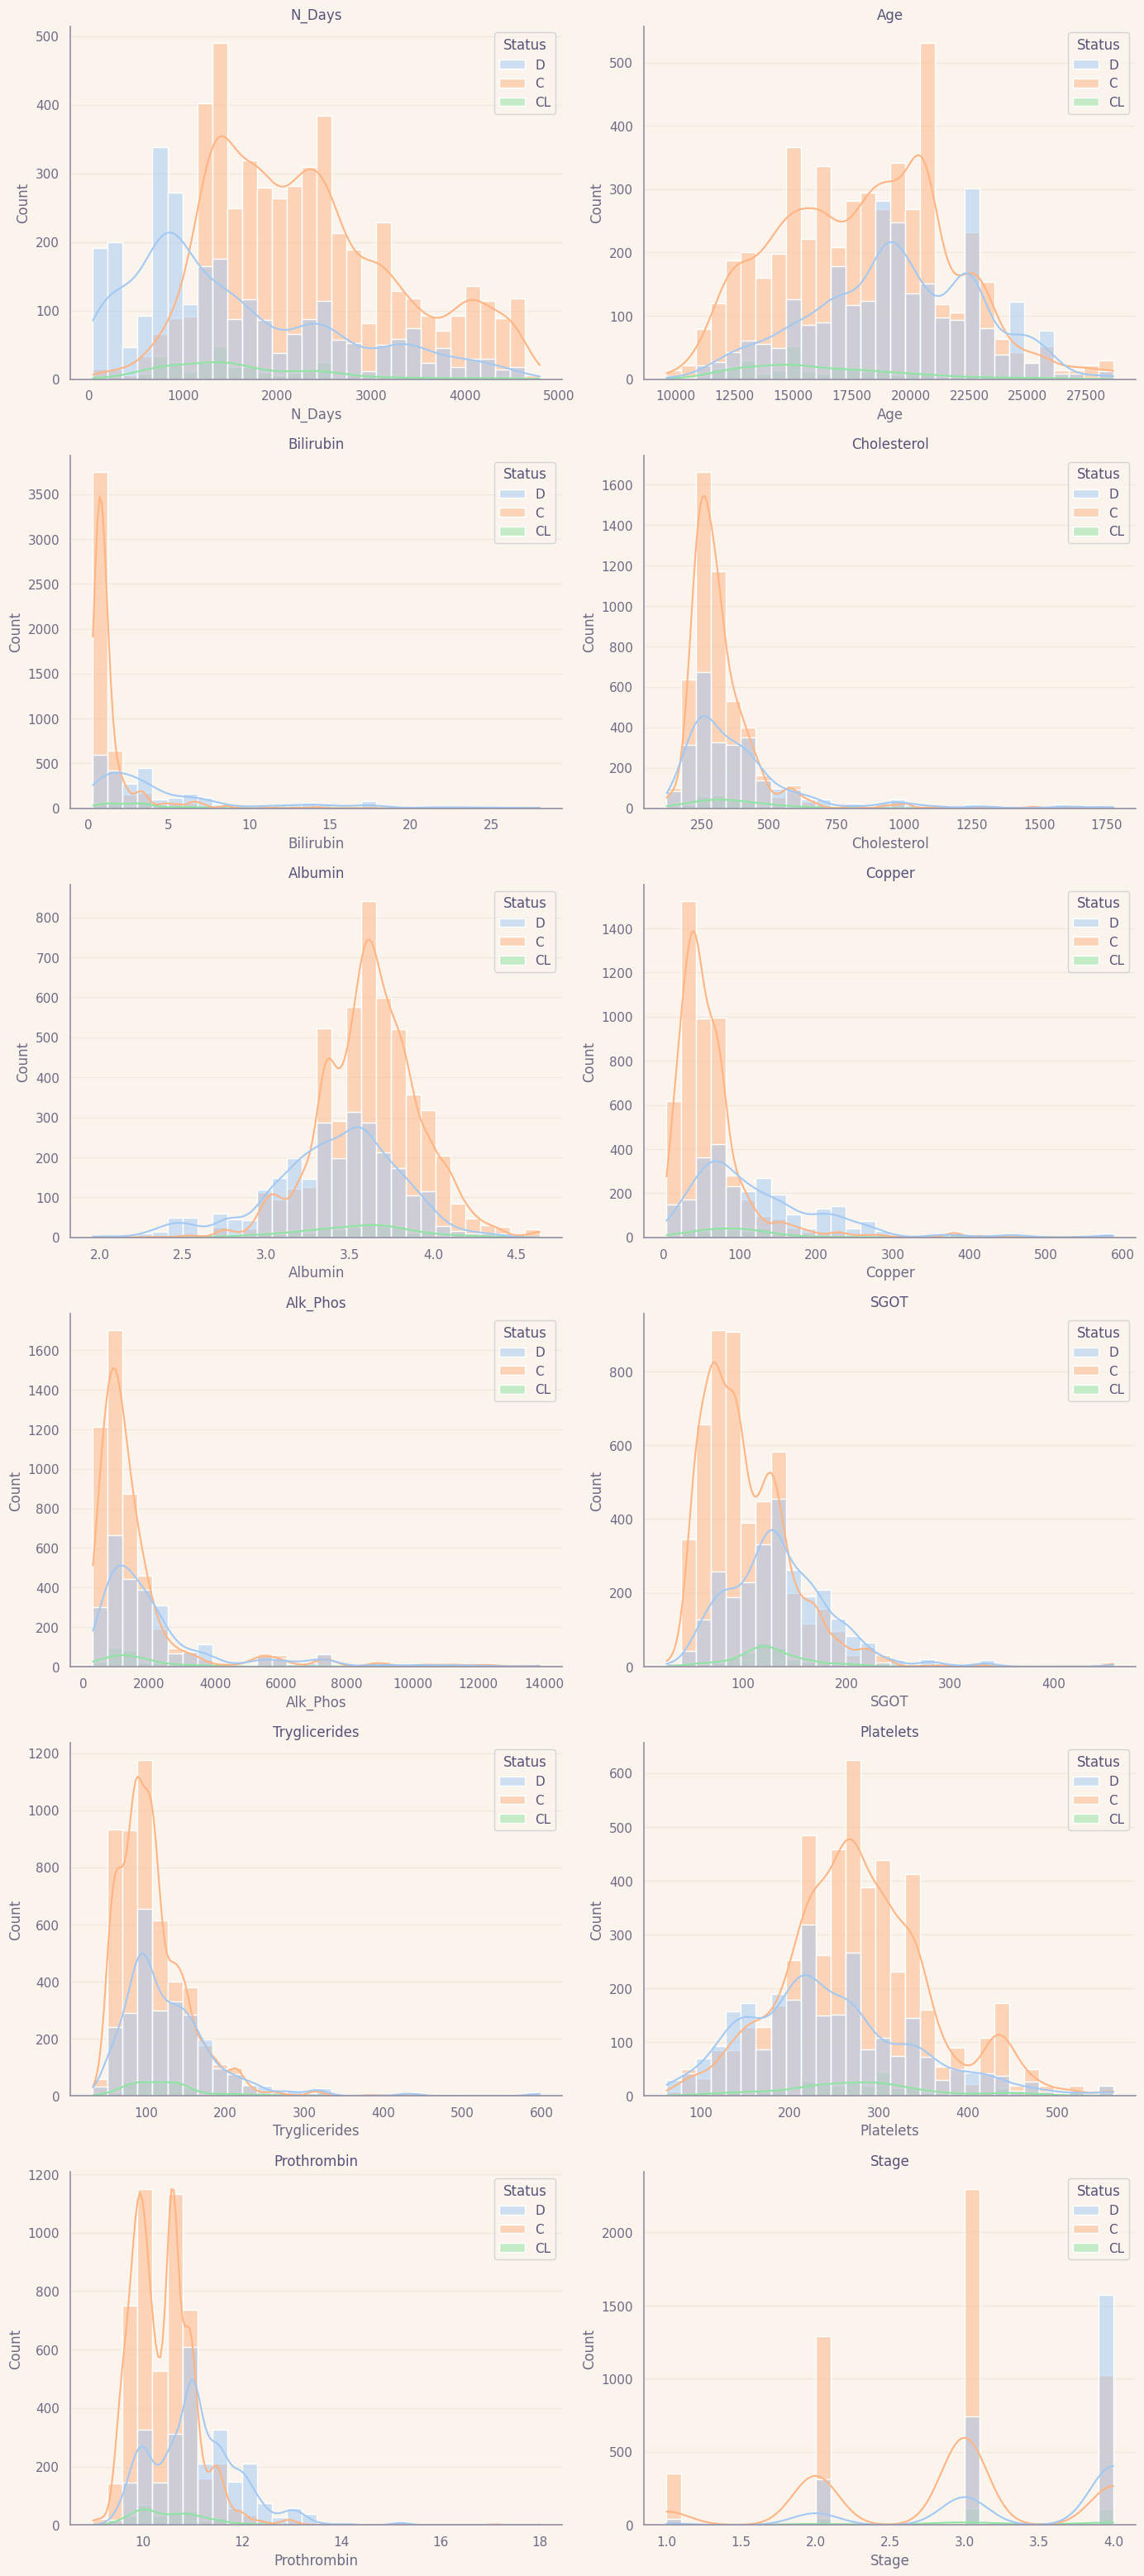

In [8]:
# Visualizing Numerical Columns
plt.figure(figsize=(14, len(numerical_columns_train)*3))
for i , col in enumerate(numerical_columns_train):
    plt.subplot(len(numerical_columns_train)//2+1,2,i+1)
    sns.histplot(x=col, hue="Status", data=train, bins=30, kde=True, palette="pastel")
    plt.title(col)
    plt.tight_layout()

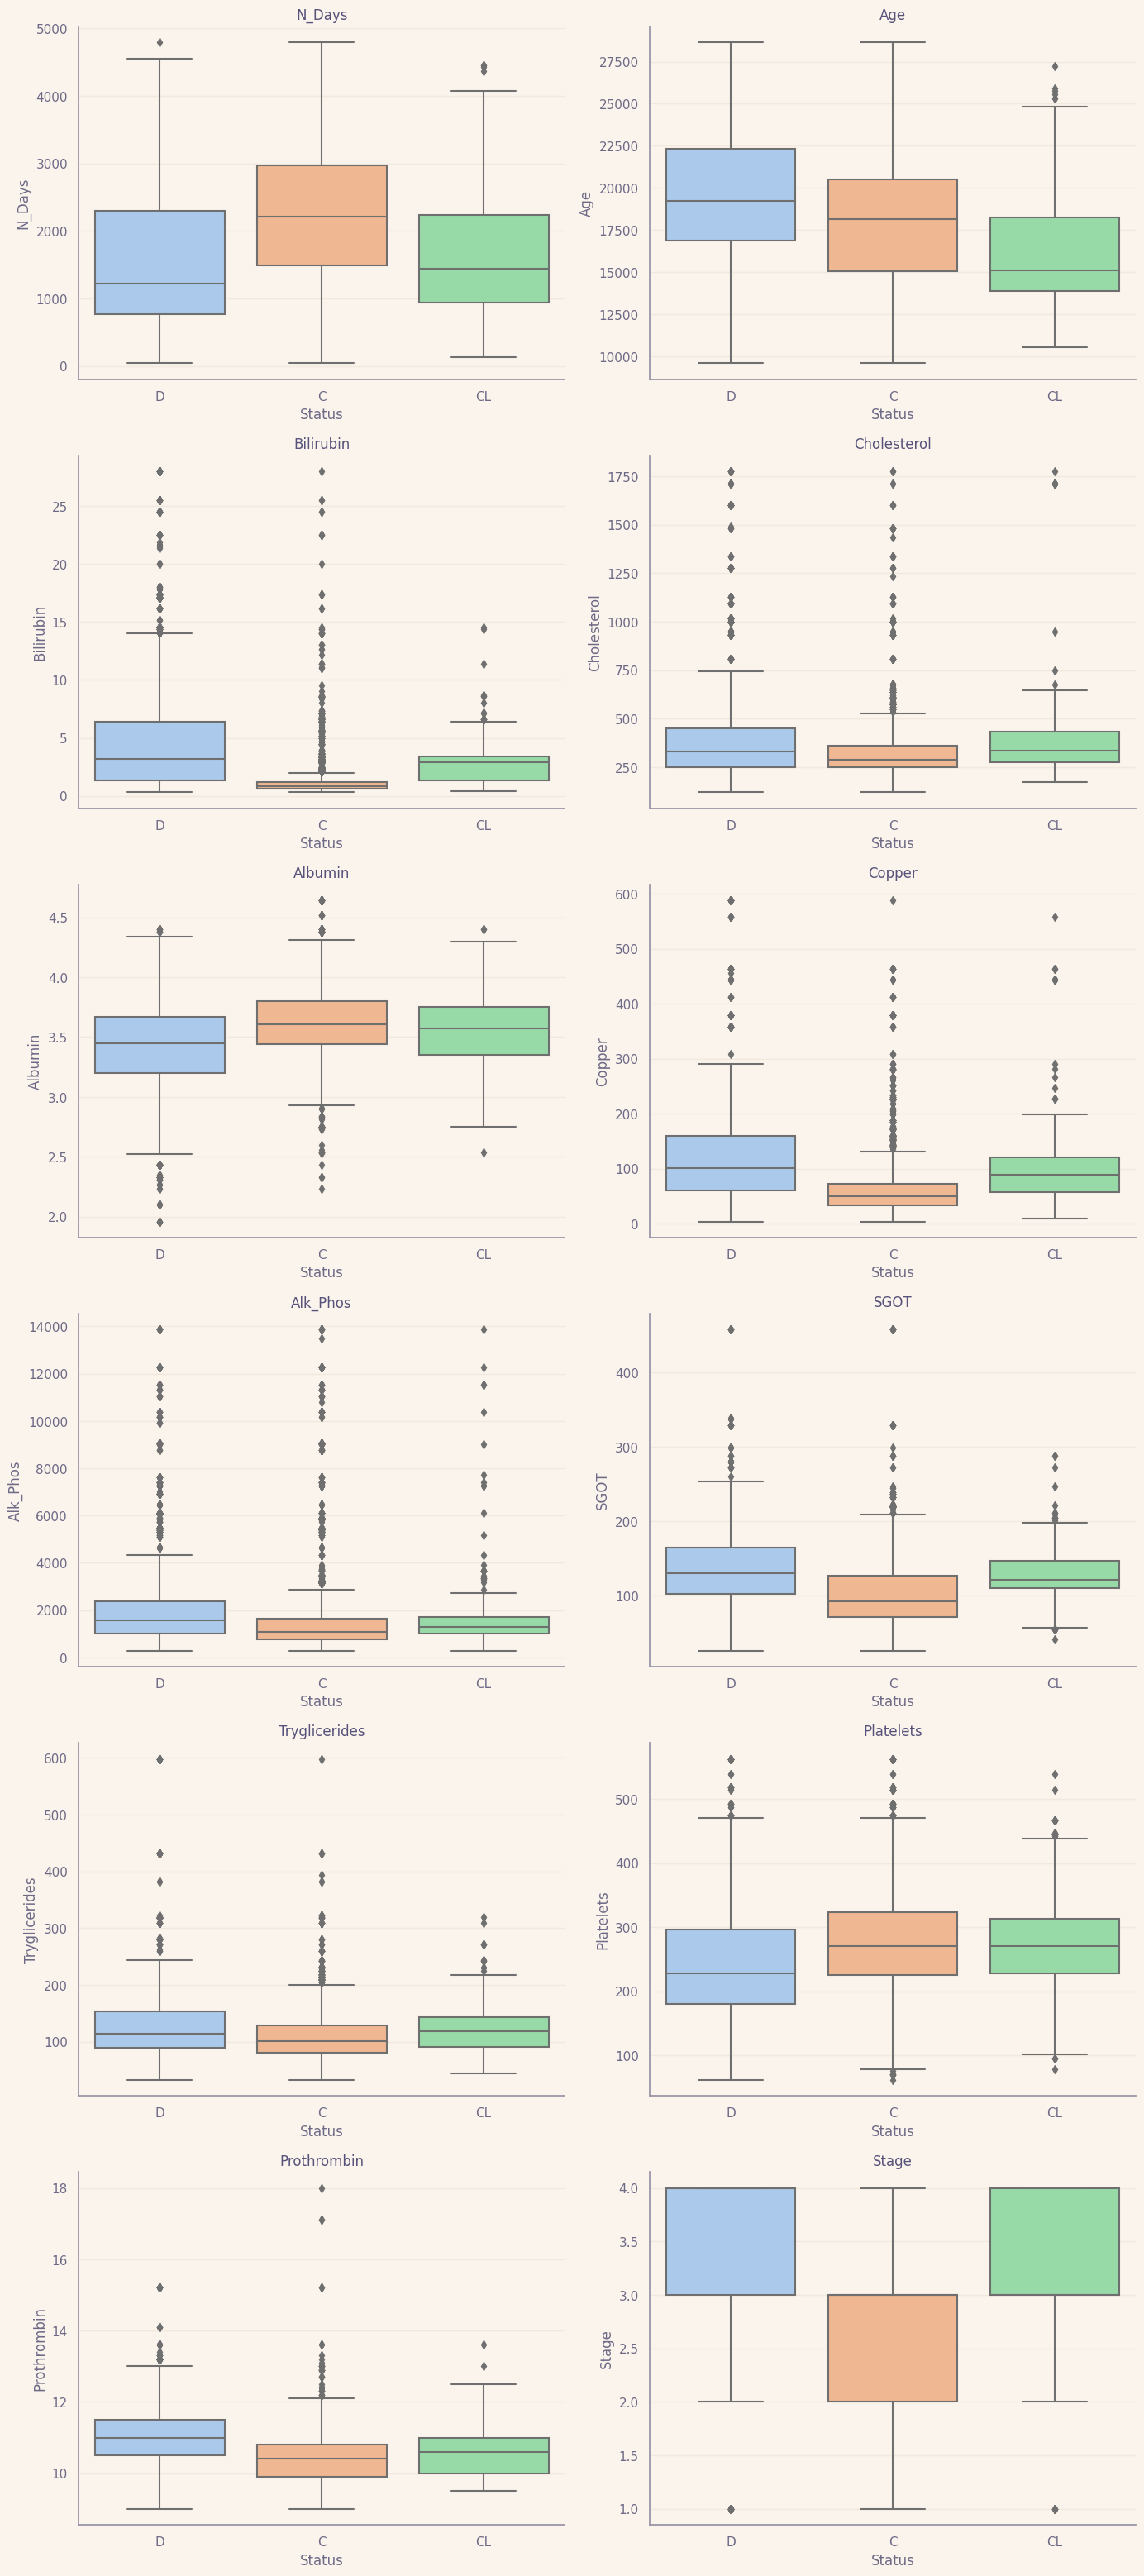

In [9]:
# Visualizing Outliers in Numerical Columns
plt.figure(figsize=(14, len(numerical_columns_train)*3))
for i , col in enumerate(numerical_columns_train):
    plt.subplot(len(numerical_columns_train)//2+1,2,i+1)
    sns.boxplot(x="Status", y=col, data=train,palette="pastel")
    plt.title(col)
    plt.tight_layout()

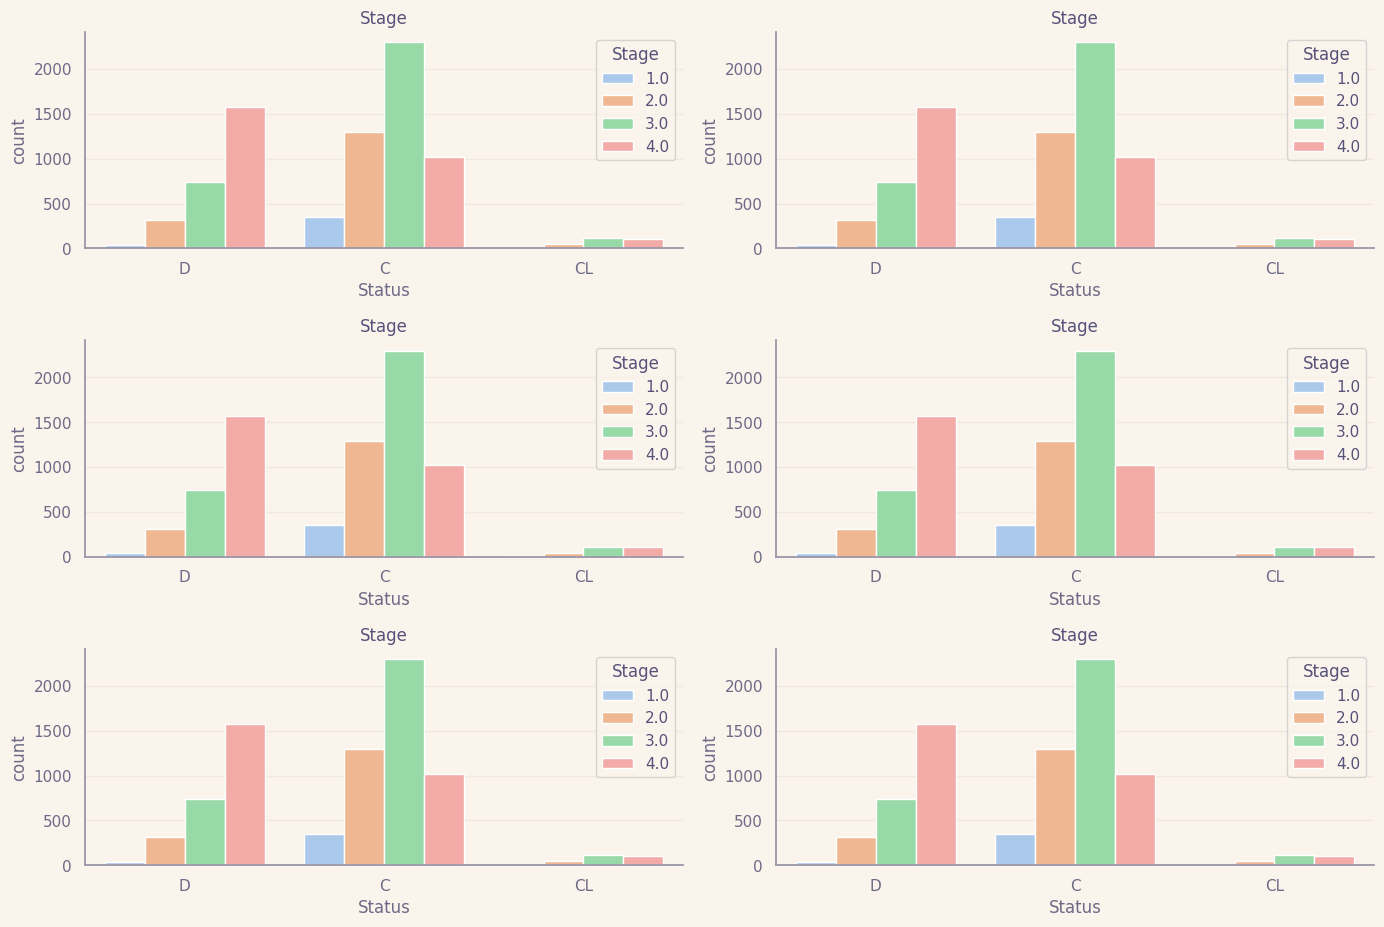

In [10]:
# Visualizing Categorical Columns
plt.figure(figsize=(14,len(categorical_columns_train)*2))
for i,column in enumerate(categorical_columns_train):
    plt.subplot(len(categorical_columns_train)//2+1,2,i+1)
    sns.countplot(x="Status", hue=col, data=train,palette="pastel")
    plt.title(col)
    plt.tight_layout()

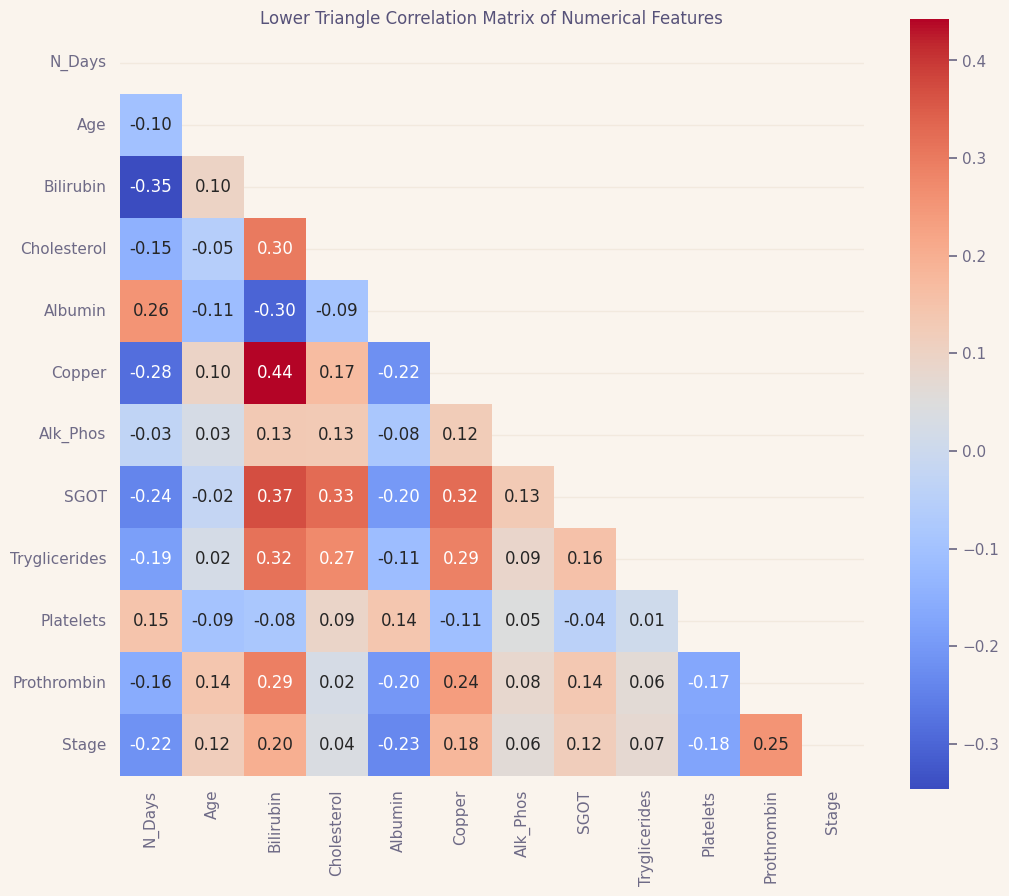

In [11]:
# Compute the correlation matrix
corr_matrix = train[numerical_columns_train].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", square=True)

# Add a title
plt.title('Lower Triangle Correlation Matrix of Numerical Features')

# Show the plot
plt.show()

In [12]:
train = pd.get_dummies(train, columns=categorical_columns_train, drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=categorical_columns_train, drop_first=True, dtype=int)

In [13]:
train['Status'] = train['Status'].map({"D":0, "C":1, "CL":2})

In [14]:
train.head(10).T

0         1         2        3         4         5  \
N_Days            999.00   2574.00   3428.00   2576.0    788.00    703.00   
Age             21532.00  19237.00  13727.00  18460.0  16658.00  19270.00   
Bilirubin           2.30      0.90      3.30      0.6      1.10      0.60   
Cholesterol       316.00    364.00    299.00    256.0    346.00    227.00   
Albumin             3.35      3.54      3.55      3.5      3.65      3.46   
Copper            172.00     63.00    131.00     58.0     63.00     34.00   
Alk_Phos         1601.00   1440.00   1029.00   1653.0   1181.00   6456.20   
SGOT              179.80    134.85    119.35     71.3    125.55     60.63   
Tryglicerides      63.00     88.00     50.00     96.0     96.00     68.00   
Platelets         394.00    361.00    199.00    269.0    298.00    213.00   
Prothrombin         9.70     11.00     11.70     10.7     10.60     11.50   
Stage               3.00      3.00      4.00      3.0      4.00      3.00   
Status              0.00      1.00      0.00      1.0      1.00      0.00   
Drug_Placebo        0.00      1.00      1.00      1.0      1.00      0.00   
Sex_M               1.00      0.00      0.00      0.0      0.00      0.00   
Ascites_Y           0.00      0.00      0.00      0.0      0.00      0.00   
Hepatomegaly_Y      0.00      0.00      1.00      0.0      1.00      1.00   
Spiders_Y           0.00      0.00      1.00      0.0      0.00      0.00   
Edema_S             0.00      0.00      0.00      0.0      0.00      0.00   
Edema_Y             0.00      0.00      1.00      0.0      0.00      0.00   

                       6         7         8        9  
N_Days           1300.00   1615.00   2050.00   2615.0  
Age             17703.00  21281.00  20684.00  15009.0  
Bilirubin           1.00      0.60      0.70      0.9  
Cholesterol       328.00    273.00    360.00    478.0  
Albumin             3.35      3.94      3.65      3.6  
Copper             43.00     36.00     72.00     39.0  
Alk_Phos         1677.00    598.00   3196.00   1758.0  
SGOT              137.95     52.70     94.55    171.0  
Tryglicerides      90.00    214.00    154.00    140.0  
Platelets         291.00    227.00    269.00    234.0  
Prothrombin         9.80      9.90      9.80     10.6  
Stage               3.00      3.00      2.00      2.0  
Status              1.00      1.00      1.00      1.0  
Drug_Placebo        1.00      1.00      0.00      0.0  
Sex_M               0.00      0.00      0.00      0.0  
Ascites_Y           0.00      0.00      0.00      0.0  
Hepatomegaly_Y      0.00      1.00      0.00      0.0  
Spiders_Y           0.00      0.00      0.00      0.0  
Edema_S             0.00      0.00      0.00      0.0  
Edema_Y             0.00      0.00      0.00      0.0

In [15]:
test.head(10).T

0         1         2         3         4         5  \
N_Days           3839.00   2468.00     51.00   2330.00   1615.00   1433.00   
Age             19724.00  14975.00  13149.00  20510.00  21904.00  20510.00   
Bilirubin           1.20      1.10      2.00      0.60      1.40      0.80   
Cholesterol       546.00    660.00    151.00    293.00    277.00    198.00   
Albumin             3.37      4.22      2.96      3.85      2.97      3.94   
Copper             65.00     94.00     46.00     40.00    121.00     38.00   
Alk_Phos         1636.00   1257.00    961.00    554.00   1110.00    911.00   
SGOT              151.90    151.90     69.75    125.55    125.00     57.35   
Tryglicerides      90.00    155.00    101.00     56.00    126.00     56.00   
Platelets         430.00    227.00    213.00    270.00    221.00    280.00   
Prothrombin        10.60     10.00     13.00     10.60      9.80      9.80   
Stage               2.00      2.00      4.00      2.00      1.00      1.00   
Drug_Placebo        0.00      0.00      1.00      0.00      0.00      0.00   
Sex_M               0.00      0.00      0.00      0.00      0.00      0.00   
Ascites_Y           0.00      0.00      0.00      0.00      0.00      0.00   
Hepatomegaly_Y      1.00      0.00      1.00      0.00      1.00      0.00   
Spiders_Y           0.00      0.00      0.00      0.00      0.00      0.00   
Edema_S             0.00      0.00      0.00      0.00      0.00      0.00   
Edema_Y             0.00      0.00      1.00      0.00      0.00      0.00   

                       6         7        8         9  
N_Days           1785.00   1925.00     41.0   1765.00  
Age             19060.00  19994.00  24064.0  28650.00  
Bilirubin           0.40      1.80     17.9      6.40  
Cholesterol       273.00    244.00    178.0    243.00  
Albumin             3.65      3.26      2.1      3.35  
Copper             25.00     64.00    220.0    380.00  
Alk_Phos          671.00   6121.80    705.0    983.00  
SGOT               84.00     60.63    338.0    158.10  
Tryglicerides     177.00     92.00    229.0    154.00  
Platelets         284.00    183.00     62.0     97.00  
Prothrombin         9.90     10.30     12.9     11.20  
Stage               3.00      4.00      4.0      2.00  
Drug_Placebo        1.00      0.00      0.0      0.00  
Sex_M               0.00      0.00      0.0      1.00  
Ascites_Y           0.00      0.00      1.0      0.00  
Hepatomegaly_Y      0.00      1.00      1.0      1.00  
Spiders_Y           0.00      0.00      0.0      0.00  
Edema_S             0.00      1.00      0.0      1.00  
Edema_Y             0.00      0.00      0.0      0.00

In [16]:
# Prepare the features (X) and target (y)
X = train.drop(columns=['Status'], axis =1)
y = train['Status']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state = 2668, stratify=y)

In [18]:
def objective_xg(trial):
    """
    Objective function for hyperparameter optimization using Optuna.

    Args:
    trial (optuna.trial): A trial instance of Optuna optimization.

    Returns:
    float: The value of the evaluation metric (log_loss) for the trial.
    """
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 300, 700),
        'min_child_weight': trial.suggest_int('min_child_weight', 0.01, 1),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1),
        'eval_metric':trial.suggest_categorical('eval_metric', ['mlogloss']),
    }

    # Initialize and fit the model
    model_xgb = XGBClassifier(**params)
    
    model_xgb.fit(X_train, y_train)

    # Predict probabilities and calculate log loss
    y_pred = model_xgb.predict_proba(X_test)
    
    return log_loss(y_test, y_pred)

In [19]:
# Create a study object and perform optimization
study_xgb = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppressing detailed logging output
study_xgb.optimize(objective_xg, n_trials=50, show_progress_bar=True)

[I 2024-01-01 10:34:40,700] A new study created in memory with name: no-name-42e9db82-d4dd-4d29-8a9c-16e898888512


  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
# Print the best parameters
print('Best parameters:', study_xgb.best_params)

Best parameters: {'booster': 'gbtree', 'max_depth': 11, 'learning_rate': 0.05431372842320632, 'n_estimators': 649, 'min_child_weight': 1, 'subsample': 0.7878931968726488, 'colsample_bylevel': 0.7727066072681129, 'colsample_bytree': 0.24762384428208759, 'colsample_bynode': 0.23045997057809997, 'reg_alpha': 0.6483256949704334, 'reg_lambda': 0.17698614154177109, 'eval_metric': 'mlogloss'}


In [21]:
# Initialize and train the model using the best parameters found
xgb = XGBClassifier(**study_xgb.best_params)
xgb.fit(X_train, y_train)

# Predict probabilities on the test set and calculate log loss
y_pred = xgb.predict_proba(X_test)

In [22]:
print('Log Loss:', log_loss(y_test, y_pred))

Log Loss: 0.37137180720060414


In [23]:
def objective_lgb(trial):
    """
    Objective function for hyperparameter optimization using Optuna.

    Args:
    trial (optuna.trial): A trial instance of Optuna optimization.

    Returns:
    float: The value of the evaluation metric (log_loss) for the trial.
    """
        
    params = {
        'logging_level': trial.suggest_categorical('logging_level', ['Silent']),
        "grow_policy" : trial.suggest_categorical('grow_policy', ["Lossguide"]),
        "max_leaves" : trial.suggest_int("max_leaves", 8, 64),
        "random_seed" : trial.suggest_categorical('random_seed', [42]),
        "iterations" : trial.suggest_int("iterations", 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        "depth" : trial.suggest_int("depth", 3, 12),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 3, 15),
        'bagging_temperature' :trial.suggest_float('bagging_temperature', 1, 3),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg',0.01,0.1),

    }
    

    # Initialize and fit the model
    model_lgb = LGBMClassifier(**params)
    
    model_lgb.fit(X_train, y_train)

    # Predict probabilities and calculate log loss
    y_pred = model_lgb.predict_proba(X_test)
    
    return log_loss(y_test, y_pred)

In [24]:
# Optimize
study_lgb = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppressing detailed logging output
study_lgb.optimize(objective_lgb, n_trials=50, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] Unknown parameter: grow_policy
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: bagging_temperature
[LightGBM] [Warning] Unknown parameter: leaf_estimation_iterations
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] num_leaves is set=31, max_leaves=38 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] Unknown parameter: grow_policy
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unk

In [25]:
# Print the best parameters
print('Best parameters:', study_lgb.best_params)

Best parameters: {'logging_level': 'Silent', 'grow_policy': 'Lossguide', 'max_leaves': 57, 'random_seed': 42, 'iterations': 237, 'learning_rate': 0.07184919320595376, 'depth': 5, 'colsample_bylevel': 0.6832311801373474, 'min_data_in_leaf': 6, 'bagging_temperature': 2.8347202204492747, 'leaf_estimation_iterations': 11, 'l2_leaf_reg': 0.09426252406805369}


In [26]:
# Initialize and train the model using the best parameters found
lgb = LGBMClassifier(**study_lgb.best_params)
lgb.fit(X_train, y_train)

# Predict probabilities on the test set and calculate log loss
y_pred = lgb.predict_proba(X_test)

[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] Unknown parameter: grow_policy
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: bagging_temperature
[LightGBM] [Warning] Unknown parameter: leaf_estimation_iterations
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] num_leaves is set=31, max_leaves=57 will be ignored. Current value: num_leaves=31


In [27]:
print('Log Loss:', log_loss(y_test, y_pred))

Log Loss: 0.3925713420712027


In [28]:
def objective_cb(trial):
    """
    Objective function for hyperparameter optimization using Optuna.

    Args:
    trial (optuna.trial): A trial instance of Optuna optimization.

    Returns:
    float: The value of the evaluation metric (log_loss) for the trial.
    """
    params = {
        'logging_level': trial.suggest_categorical('logging_level', ['Silent']),
        "grow_policy" : trial.suggest_categorical('grow_policy', ["Lossguide"]),
        "max_leaves" : trial.suggest_int("max_leaves", 8, 64),
        "random_seed" : trial.suggest_categorical('random_seed', [42]),
        "iterations" : trial.suggest_int("iterations", 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        "depth" : trial.suggest_int("depth", 3, 12),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 3, 15),
        'bagging_temperature' :trial.suggest_float('bagging_temperature', 1, 3),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg',0.01,0.1),

    }

    
    model_cb = CatBoostClassifier(**params)
    
    model_cb.fit(X_train, y_train)
    
    y_pred = model_cb.predict_proba(X_test)
    
    return log_loss(y_test, y_pred)

In [29]:
# Optimize
study_cb = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppressing detailed logging output
study_cb.optimize(objective_cb, n_trials=50, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [30]:
# Print the best parameters
print('Best parameters:', study_cb.best_params)

Best parameters: {'logging_level': 'Silent', 'grow_policy': 'Lossguide', 'max_leaves': 59, 'random_seed': 42, 'iterations': 299, 'learning_rate': 0.062189342139459466, 'depth': 10, 'colsample_bylevel': 0.49937935414801526, 'min_data_in_leaf': 3, 'bagging_temperature': 1.2485788718664637, 'leaf_estimation_iterations': 1, 'l2_leaf_reg': 0.0381067691394153}


In [31]:
cb = CatBoostClassifier(**study_cb.best_params)
cb.fit(X_train, y_train)
y_pred = cb.predict_proba(X_test)

In [32]:
print('Log Loss:', log_loss(y_test, y_pred))

Log Loss: 0.38937897390083576


In [33]:
# Create a voting classifier
voting_clf = VotingClassifier(estimators=[('xgb', xgb), ('lgb', lgb), ('cb', cb)], voting='soft')

In [34]:
# Train the voting classifier
voting_clf.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: logging_level
[LightGBM] [Warning] Unknown parameter: grow_policy
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: bagging_temperature
[LightGBM] [Warning] Unknown parameter: leaf_estimation_iterations
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] num_leaves is set=31, max_leaves=57 will be ignored. Current value: num_leaves=31


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=0.7727066072681129,
                                            colsample_bynode=0.23045997057809997,
                                            colsample_bytree=0.24762384428208759,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importa...
                              LGBMClassifier(bagging_temperature=2.8347202204492747,
                                             colsample_bylevel=0.6832311801373474,
                                             depth=5, grow_policy='Lossguide',
                                             iterations=237,
                                             l2_leaf_reg=0.09426252406805369,
                                             leaf_estimation_iterations=11,
                                             learning_rate=0.07184919320595376,
                                             logging_level='Silent',
                                             max_leaves=57, min_data_in_leaf=6,
                                             random_seed=42)),
                             ('cb',
                              <catboost.core.CatBoostClassifier object at 0x7a48069d4190>)],
                 voting='soft')

In [35]:
# Predict and evaluate
y_pred = voting_clf.predict_proba(X_test)
print('Voting Classifier Log Loss:', log_loss(y_test, y_pred))

Voting Classifier Log Loss: 0.3767332023167442


In [36]:
sample_submisiion["Status_C"] =  voting_clf.predict_proba(test)[:, 1]
sample_submisiion["Status_CL"] =  voting_clf.predict_proba(test)[:,2]
sample_submisiion["Status_D"] =  voting_clf.predict_proba(test)[:, 0]

sample_submisiion.to_csv('submission.csv',index=False)
sample_submisiion

id  Status_C  Status_CL  Status_D
0      7905  0.492619   0.018580  0.488801
1      7906  0.766980   0.077300  0.155721
2      7907  0.026467   0.009052  0.964481
3      7908  0.953870   0.003951  0.042180
4      7909  0.889528   0.020986  0.089486
...     ...       ...        ...       ...
5266  13171  0.890814   0.046926  0.062260
5267  13172  0.977379   0.001935  0.020686
5268  13173  0.915037   0.004379  0.080584
5269  13174  0.985255   0.005109  0.009636
5270  13175  0.308849   0.009553  0.681597

[5271 rows x 4 columns]